In [14]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import ViT_B_16_Weights
from torchvision.models.vision_transformer import vit_b_16
import math
import torch.backends.mps

from hyperparams import *
import data
import eval
import vit
import train
import utils


In [2]:
import importlib
def reload():
    importlib.reload(data)
    importlib.reload(eval)
    importlib.reload(vit)
    importlib.reload(train)
    importlib.reload(utils)

In [3]:
SEED = 100

In [4]:
device = utils.get_device()

Using device: mps


In [5]:
MAX_TEST_BATCHES_N = math.floor(MAX_ITERATIONS_PER_EPOCH*0.2/0.8)

#how many times during one epoch to calculate averaged train metrics and evaluate the model on the test set
EVALS_PER_EPOCH = 3

In [6]:
print("Loading CIFAR-10 dataset")
train_ds, train_dl = data.load_CIFAR(train=True, batch_size=FT_BATCH, max_batches_n=MAX_ITERATIONS_PER_EPOCH, transforms=ViT_B_16_Weights.DEFAULT.transforms(), seed=SEED)
test_ds, test_dl = data.load_CIFAR(train=False, batch_size=FT_BATCH, max_batches_n=MAX_TEST_BATCHES_N, transforms=ViT_B_16_Weights.DEFAULT.transforms(), seed=SEED)

Loading CIFAR-10 dataset
Files already downloaded and verified
Created 100 train batches of size 128
Files already downloaded and verified
Created 25 test batches of size 128


In [7]:
classes = test_ds.classes

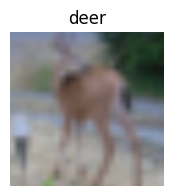

In [8]:
utils.show(test_ds, 100)

Fine-tuning of reference model

In [9]:
print("Creating the reference model")
weights = ViT_B_16_Weights.DEFAULT
torch.manual_seed(SEED)
ref_model = vit_b_16(weights=weights).to(device)

Creating the reference model


In [10]:
print("Freezing the model and swapping it's classification head")
#freeze the ref model
for p in ref_model.parameters():
    p.requires_grad = False

#swap the classification layer
ref_model.heads = nn.Sequential(nn.Linear(in_features=D, out_features=len(classes))).to(device)
# summary(ref_model, depth=4, input_size=(1, 3, IMAGE_W, IMAGE_W),col_names=["kernel_size", "input_size", "output_size", "num_params","trainable"], row_settings=["var_names"],)


Freezing the model and swapping it's classification head


In [12]:
optim = torch.optim.SGD(ref_model.parameters(), lr=LR, momentum=MOMENTUM)

In [ ]:
print("Fine-tuning the reference model")
torch.manual_seed(SEED)
train_metrics, test_metrics = train.train(ref_model, EPOCHS, train_dl, test_dl, device, len(classes), optim, nn.CrossEntropyLoss(), EVALS_PER_EPOCH)

In [ ]:
eval.plot_metrics(train_metrics, test_metrics)

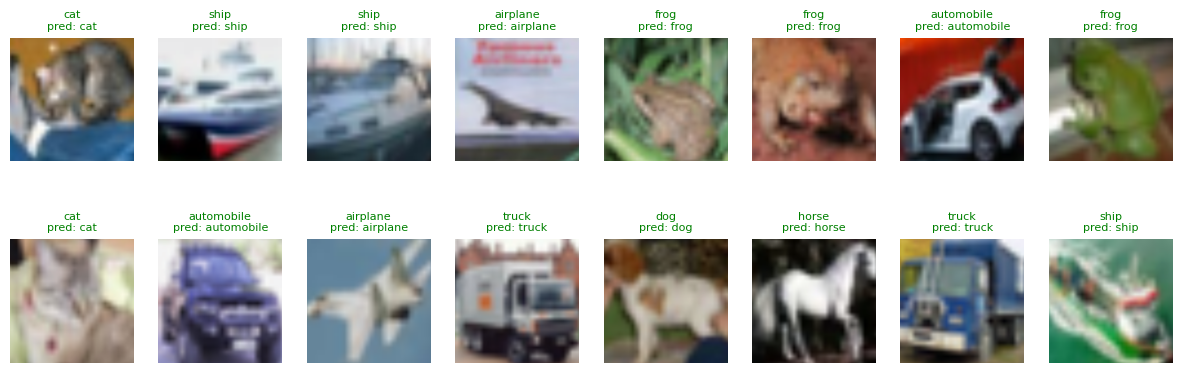

In [19]:
eval.eval_show(ref_model, test_ds, n=16, page=0)

In [17]:
accuracy = test_metrics[eval.Metrics.ACCURACY.value][-1].item()
utils.save_model(ref_model, accuracy, "FT_CIFAR")

Model saved to /Users/yehormanevych/Projects/ViT/models/2023-08-29_16.38.31_VisionTransformer_94%_FT_cifar.pth


PosixPath('models/2023-08-29_16.38.31_VisionTransformer_94%_FT_cifar.pth')

Fine-tuning of the replicated model

In [27]:
IMAGENET_CLASSES_N = 1000

In [28]:
print("Creating the replicated model")
torch.manual_seed(SEED)
m = vit.ViT(D, IMAGE_W, PATCH, HEADS, DMLP, L, IMAGENET_CLASSES_N, DROPOUT, NORM_EPS)

Creating the replicated model


In [32]:
print("Loading last saved ViT model")
m = utils.load_last_model(m)

Loading last saved ViT model
Loading model from /Users/yehormanevych/Projects/ViT/models/2023-08-29_13.36.38_ViT_93%.pth


In [33]:
print("Freezing the model and swapping it's classification head")
#freeze the model
for p in m.parameters():
    p.requires_grad = False

#swap the classification layer
m.head = nn.Linear(in_features=D, out_features=len(classes))
m.to(device)

Freezing the model and swapping it's classification head


ViT(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=-2, end_dim=-1)
  (encoder): Encoder(
    (layers): Sequential(
      (0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (msa): MSA()
        (dropout): Dropout(p=0.1, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (dropout): Dropout(p=0.1, inplace=False)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (msa): MSA()
        (dropout): Dropout(p=0.1, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (lin1): Linear(in_features=768, out_features=3072, bias=

In [34]:
optim = torch.optim.SGD(m.parameters(), lr=LR, momentum=MOMENTUM)

In [ ]:
print("Fine-tuning the replicated model")
torch.manual_seed(SEED)
train_metrics, test_metrics = train.train(m, EPOCHS, train_dl, test_dl, device, len(classes), optim, nn.CrossEntropyLoss(), EVALS_PER_EPOCH)

In [ ]:
eval.plot_metrics(train_metrics, test_metrics)

In [ ]:
accuracy = test_metrics[eval.Metrics.ACCURACY.value][-1].item()
utils.save_model(ref_model, accuracy, "FT_CIFAR")